In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime
from learntools.time_series.style import *

from pathlib import Path
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

In [2]:
comp_dir = Path('../input/store-sales-time-series-forecasting')
train = pd.read_csv(comp_dir / 'train.csv')
test = pd.read_csv(comp_dir / 'test.csv')
stores = pd.read_csv(comp_dir / 'stores.csv')
oil = pd.read_csv(comp_dir / 'oil.csv')
transactions =  pd.read_csv(comp_dir / 'transactions.csv')
holidays_events = pd.read_csv(comp_dir / 'holidays_events.csv')

In [3]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [4]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

## MERGING DATA SETS
Para empezar, lo que vamos a hacer va a ser combinar los diferentes DataFrames de datos de los que disponemos con el set de entrenamiento `train`, para así disponer de todos los datos en un único marco de datos: 

In [5]:
train = train.merge(stores, how="left", on='store_nbr')   
train = train.merge(oil, how="left", on='date')      
train = train.merge(transactions, how="left", on=['date','store_nbr'])  
train = train.merge(holidays_events,on='date',how='left')
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,transactions,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False


Una vez hemos combinado todos los datos en un solo DataFrame, procederemos al estudio de los datos. Lo primero que vamos a hacer, va a ser renombrar ciertas columnas para evitar confusiones.

In [6]:
train = train.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

También vamos a desglosar la fecha en diferentes columnas: 
* Una para el año
* Una para el mes
* Una para la semana
* Una para el trimestre del año
* Una para el día de la semana

In [7]:
train.date = pd.to_datetime(train.date)
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.isocalendar().week
train['quarter'] = train['date'].dt.quarter
train['day_of_week'] = train['date'].dt.day_name()
train.head(1)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday


## DATA STUDY
En esta sección vamos a realizar diversos estudios de los datos obtenidos anteriormente, a partir del empleo diversas gráficas. Nos centraremos en ver: 
* Las tiendas con mayor porcentaje de ventas.
* Los tipos de productos más vendidos. 
* Las ventas de cada cluster
* El histórico de ventas para cada uno de los meses del año. 
* Los porcentajes de ventas por trimestre del año
* La media de ventas por semana. 

In [8]:
# data
# Agrupamos por tipo de tienda, y al DataFrame le añadimos un único campo 'sales' con la media de los precios de venta ordenados ascendentemente
df_st_sa = train.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fa_sa = train.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_cl_sa = train.groupby('cluster').agg({"sales" : "mean"}).reset_index() 
# chart color
df_fa_sa['color'] = '#496595'
df_fa_sa['color'][2:] = '#c6ccd8'
df_cl_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Top 10 Highest Product Sales", "Highest Sales in Stores", "Clusters Vs Sales"))

fig.add_trace(go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'], marker=dict(color= df_fa_sa['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_st_sa['sales'], labels=df_st_sa['store_type'], name='Store type',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
fig.add_trace(go.Bar(x=df_cl_sa['cluster'], y=df_cl_sa['sales'], 
                     marker=dict(color= df_cl_sa['color']), name='Cluster'), 
                     row=2, col=1)

# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_cl_sa.cluster, ticktext=[i for i in range(1,17)], row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

📌 **Interpret:** Highest sales are made by the products like grocery and beverages.
Store A has the highest sales which is 38%.

In [9]:
# data 
df_2013 = train[train['year']==2013][['month','sales']]
df_2013 = df_2013.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s13'})
df_2014 = train[train['year']==2014][['month','sales']]
df_2014 = df_2014.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s14'})
df_2015 = train[train['year']==2015][['month','sales']]
df_2015 = df_2015.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s15'})
df_2016 = train[train['year']==2016][['month','sales']]
df_2016 = df_2016.groupby('month').agg({"sales" : "mean"}).reset_index().rename(columns={'sales':'s16'})
df_2017 = train[train['year']==2017][['month','sales']]
df_2017 = df_2017.groupby('month').agg({"sales" : "mean"}).reset_index()
df_2017_no = pd.DataFrame({'month': [9,10,11,12], 'sales':[0,0,0,0]})
df_2017 = df_2017.append(df_2017_no).rename(columns={'sales':'s17'})
df_year = df_2013.merge(df_2014,on='month').merge(df_2015,on='month').merge(df_2016,on='month').merge(df_2017,on='month')

# top levels
top_labels = ['2013', '2014', '2015', '2016', '2017']

colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)',
          'rgba(122, 120, 168, 0.8)', 'rgba(164, 163, 204, 0.85)',
          'rgba(190, 192, 213, 1)']

# X axis value 
df_year = df_year[['s13','s14','s15','s16','s17']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_2013['month'] =['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
y_data = df_2013['month'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(title='Avg Sales for each Year',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

📌 **Interpret:** Highest sales are made in December month and then decreases in January.
Sales are increasing gradually from 2013 to 2017.
Note: We don't have data for 2017: 9th to 12th month.


In [10]:
# data
df_m_sa = train.groupby('month').agg({"sales" : "mean"}).reset_index()
df_m_sa['sales'] = round(df_m_sa['sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['sales'].astype(str) 

df_w_sa = train.groupby('week').agg({"sales" : "mean"}).reset_index() 
df_q_sa = train.groupby('quarter').agg({"sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

📌 **Interpret:** Highest sales are made in the last quarter of the year, followed by the third. The one with less saling is the first one. 

In [11]:
# data
df_dw_sa = train.groupby('day_of_week').agg({"sales" : "mean"}).reset_index()
df_dw_sa.sales = round(df_dw_sa.sales, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='sales', title='Avg Sales vs Day of Week',
             color_discrete_sequence=['#c6ccd8'], text='sales',
             category_orders=dict(day_of_week=["Monday","Tuesday","Wednesday","Thursday", "Friday","Saturday","Sunday"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))


📌 **Interpret:** Highest sales are made in the weekend. Surprisingly, Mondays are the third day with most sales. 

Text(0.5, 1.0, 'State vs Sales of Store A (per year)')

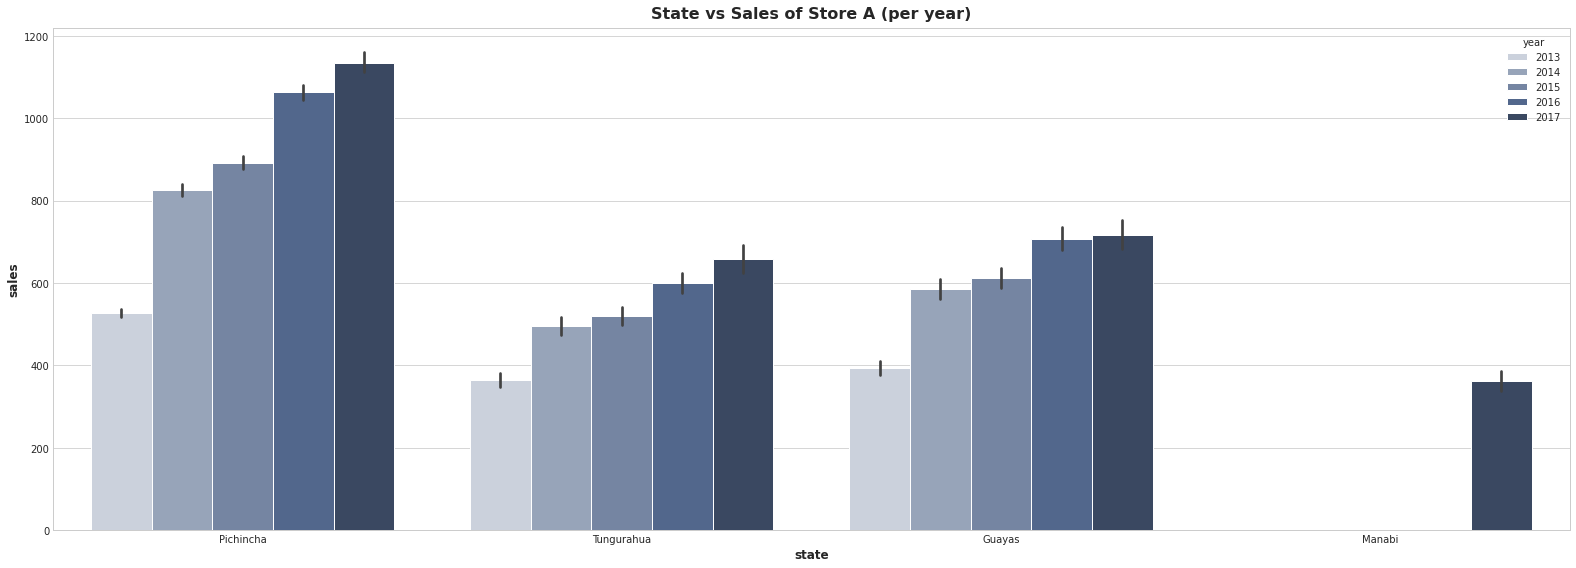

In [12]:
df_train = train[['state','sales','store_type','year']]
fig = plt.figure(figsize=(22,8))
sns.set_style('whitegrid')
my_palette = ['#C8D0DF','#91A2BF','#6D83AA','#496595','#334668']
sns.barplot(x='state',y='sales',hue = 'year', palette = my_palette, data=df_train[df_train['store_type'] == 'A'])
plt.title("State vs Sales of Store A (per year)")

📌 **Interpret:** Highest sales are made in Pichincha state. Sales have been increasing during the recorded period in every state, except Manabi where Store A is new in 2017. 

## DATA CLEANING
Lo siguiente que vamos a realizar es la limpieza de datos. Para ello, vamos a empezar considerando el problema de los datos faltantes que poseemos en nuestro set de entrenamiento. 

In [13]:
pd.isnull(train).sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
dcoilwtico       955152
transactions     249117
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
year                  0
month                 0
week                  0
quarter               0
day_of_week           0
dtype: int64

Empecemos por el precio del aceite. Para ello, primero vamos a ver como se ha ido distribuyendo éste a lo largo de los años. 

In [14]:
moving_average_oil = oil.rolling(
    window=183,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=92,  # choose about half the window size
).median()              # compute the mean (could also do median, std, min, max, ...)
moving_average_oil['date'] = oil['date']
moving_average_oil.loc[[0,1],'dcoilwtico'] = moving_average_oil.loc[2,'dcoilwtico']
moving_average_oil.date = pd.to_datetime(moving_average_oil.date)

In [15]:
df_yr_oil = oil[['date','dcoilwtico']]
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.08,                    
                    subplot_titles=("Oil price during time"))
fig.add_trace(go.Scatter(x=df_yr_oil['date'], y=df_yr_oil['dcoilwtico'], mode='lines', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Oil price'), 
                     row=1, col=1)
fig.add_trace(go.Scatter(x=moving_average_oil.date,y=moving_average_oil.dcoilwtico,mode='lines',name='Trend'))
fig.update_layout(height=350, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Oil price trend during time",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

Tal y como apreciamos en el gráfico anterior, podemos dividir la tendencia de los precios del aceite en tres fases. La primera y última de ellas, Jan2013-Jul2014 y Jan2015-Jul2107 correspondientemente, presentan tendencias estabilizadas con altibajos. Sin embargo, en la segunda de ellas, Jul2014-Jan2015, los precios del aceite disminuyen considerablemente. Es por esto, que vamos a proceder de la siguiente manera para reemplazar los valores faltantes de la columna: reemplazaremos cada valor faltante por la media de precios del aceite de la fase a la que pertenezca.     

In [16]:
train.dcoilwtico.isnull().sum()

955152

In [17]:
primera_fase = train[train['date'] < datetime.datetime(2014,7,1)]
media = primera_fase.dcoilwtico.describe()[1]
primera_fase.loc[:,'dcoilwtico'] = primera_fase.loc[:,'dcoilwtico'].replace(np.nan,media)

segunda_fase = train[train['date'] < datetime.datetime(2015,1,1)]
segunda_fase = segunda_fase[segunda_fase['date'] >= datetime.datetime(2014,7,1)]
media = segunda_fase.dcoilwtico.describe()[1]
segunda_fase.loc[:,'dcoilwtico'] = segunda_fase.loc[:,'dcoilwtico'].replace(np.nan,media)

ultima_fase = train[train['date'] >= datetime.datetime(2015,1,1)]
media = ultima_fase.dcoilwtico.describe()[1]
ultima_fase.loc[:,'dcoilwtico'] = ultima_fase.loc[:,'dcoilwtico'].replace(np.nan,media)

train.loc[0:985445,'dcoilwtico'] = primera_fase
train.loc[985446:1316897,'dcoilwtico'] = segunda_fase
train.loc[1316898:3054348,'dcoilwtico'] = ultima_fase
train.dcoilwtico.isnull().sum()

0

Con respecto a las transacciones, comprendemos que al no haber datos registrados, esta es de 0. Por tanto, sustituiremos los valores faltantes por dicho valor.

In [18]:
train.transactions = train.transactions.replace(np.nan,0)
pd.isnull(train.dcoilwtico).sum()

0

In [19]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
dcoilwtico            0
transactions          0
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
year                  0
month                 0
week                  0
quarter               0
day_of_week           0
dtype: int64

In [20]:
holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


Como vemos arriba el DataFrame de `holidays_events` contiene una fila para cada uno de los días festivos, bien sea a nivel nacional, regional o local. La columna de transferred hace referencia a si la festividad ha sido movida de día o no. Suponemos entonces que los datos faltantes correspondientes a este DataFrame en el set de entrenamiento se corresponden con aquellos días para los que no hay registrada ninguna festividad. Por tanto, reemplazaremos el `type` por `Working days`. El resto de variables categóricas de este DataFrame las cambiaremos por la cadena vacía, y en `transferred` pondremos todos los valores a `false`.

In [21]:
train[['locale','locale_name', 'description']] = train[['locale','locale_name', 'description']].replace(np.nan,'')
train['holiday_type'] = train['holiday_type'].replace(np.nan,'Working Day')
train['transferred'] = train['transferred'].replace(np.nan,False)

In [22]:
train.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
dcoilwtico      0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
year            0
month           0
week            0
quarter         0
day_of_week     0
dtype: int64

In [23]:
train[['store_type', 'holiday_type', 'locale', 'day_of_week']].holiday_type.value_counts()

Working Day    2551824
Holiday         304722
Event            99792
Additional       67716
Transfer         16038
Work Day          8910
Bridge            5346
Name: holiday_type, dtype: int64

In [24]:
indices_holiday = train.index[train['holiday_type'].isin(['Event','Additional','Transfer','Work Day','Bridge'])].tolist()
train = train = train.drop(indices_holiday,axis=0)

In [25]:
train[['store_type', 'holiday_type', 'locale', 'day_of_week']].locale.value_counts()

            2551824
Local        188892
National      83754
Regional      32076
Name: locale, dtype: int64

In [26]:
indices_locale = train.index[train['locale'].isin(['National','Regional'])].tolist()
train = train.drop(indices_locale,axis=0)

Una vez resuelto el problema de los datos faltantes, vamos a afrontar el problema de las variables categóricas. Vemos cuáles son los datos categóricos: 

In [27]:
train.dtypes

id                       int64
date            datetime64[ns]
store_nbr                int64
family                  object
sales                  float64
onpromotion              int64
city                    object
state                   object
store_type              object
cluster                  int64
dcoilwtico             float64
transactions           float64
holiday_type            object
locale                  object
locale_name             object
description             object
transferred               bool
year                     int64
month                    int64
week                    UInt32
quarter                  int64
day_of_week             object
dtype: object

Empecemos viendo la cardinalidad de cada una de las variables categóricas, para así saber a cúales vamos a aplicarle `oneHot Encoding` y a cúales `Ordinal Encoding`. 

In [28]:
categorical_cols = [col for col in train.columns if train[col].dtype == 'object']
categorical_cols

['family',
 'city',
 'state',
 'store_type',
 'holiday_type',
 'locale',
 'locale_name',
 'description',
 'day_of_week']

In [29]:
train[categorical_cols].describe().loc['unique',:]

family          33
city            22
state           16
store_type       5
holiday_type     2
locale           2
locale_name     20
description     25
day_of_week      7
Name: unique, dtype: object

In [30]:
OH_cols = [col for col in train.columns if train[col].dtype == 'object' and train[col].describe()[1]<15 and col != 'transferred']
OH_cols

['store_type', 'holiday_type', 'locale', 'day_of_week']

In [31]:
ORD_cols = [col for col in train.columns if (train[col].dtype == 'object' and train[col].describe()[1]>=15)]
ORD_cols

['family', 'city', 'state', 'locale_name', 'description']

Empezaremos por las variables correspondientes al `Ordinal Encoding`: 

In [32]:
ordinal_encoder = OrdinalEncoder()

In [33]:
label_train = train.copy()
label_train[ORD_cols] = ordinal_encoder.fit_transform(train[ORD_cols])

In [34]:
OH_label_train = label_train.copy()

In [35]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(OH_label_train[OH_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = OH_label_train.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = OH_label_train.drop(OH_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_train = pd.concat([num_X_train, OH_cols_train], axis=1)

In [36]:
OH_train

,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,6,7,8,9,10,11,12,13,14,15
1782,1782,2013-01-02,1,0.0,2.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1783,1783,2013-01-02,1,1.0,0.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1784,1784,2013-01-02,1,2.0,2.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1785,1785,2013-01-02,1,3.0,1091.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1786,1786,2013-01-02,1,4.0,0.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,28.0,438.133,0,18.0,12.0,6,47.57,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3054344,3000884,2017-08-15,9,29.0,154.553,1,18.0,12.0,6,47.57,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3054345,3000885,2017-08-15,9,30.0,2419.729,148,18.0,12.0,6,47.57,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3054346,3000886,2017-08-15,9,31.0,121.000,8,18.0,12.0,6,47.57,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Como con los encoders anteriores no podemos cambiar el valor de una variable booleana, lo realizamos a mano: 

In [37]:
OH_train['transferred'] = OH_train['transferred'].replace([False,True],[0,1])
OH_train.transferred.unique()

array([0, 1])

Como el dato de la fecha completa no nos sirve de mucho, una vez que hemos creado columnas para año, mes ... la eliminamos de nuestro conjunto de datos. 

In [38]:
#OH_train = OH_train.drop('date',axis=1)
#OH_train.columns

Ahora, tocaría repetir todo este proceso para el set de testing. Con el fin de favorecer la sencillez de este proyecto, vamos a cargar directamente el set de test con los cambios ya realizados. 

In [39]:
OH_test = pd.read_csv('../input/test-cleaned/test_cleaned.csv')
OH_test = OH_test.drop('Unnamed: 0',axis=1)
OH_test['date'] = test['date']

## Predictions
Una vez hemos hecho el data cleaning, procedemos a la realizar la parte relacionada con el Machine Learning y la predicción de precios. En nuestro caso, vamos a utilizar el algoritmo de regresión linear. Para ello primero veremos las características temporales correspondientes a los datos que poseemos. 
### Trend

In [40]:
sales = train.groupby('date').agg({"sales" : "mean"}).reset_index()
sales.set_index('date',inplace=True)
moving_average = sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)
moving_average['date'] = sales.index

In [41]:
fig = make_subplots(rows=1, cols=1, vertical_spacing=0.08,                    
                    subplot_titles=("Sales 365 - Day Moving Average"))
fig.add_trace(go.Scatter(x=sales.index, y=sales['sales'], mode='lines', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#334668'), name='365-Day Moving Average'))
fig.add_trace(go.Scatter(x=moving_average.date,y=moving_average.sales,mode='lines',name='Trend'))
fig.update_layout(height=350, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Sales trend during years",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

### Seasonality

In [42]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    #.loc['2017']
)

Text(0.5, 1.0, 'Seasonal Plot (year/dayofyear)')

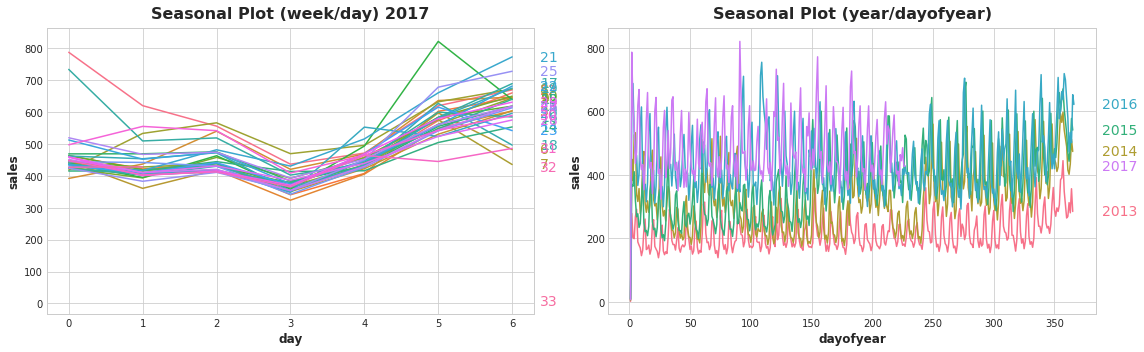

In [43]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X['year'] = X.index.year
X['dayofyear'] = X.index.dayofyear
fig,(ax0,ax1) = plt.subplots(1, 2, figsize=(16, 5))
seasonal_plot(X.loc['2017'], y='sales', period="week", freq="day", ax=ax0)
ax0.set_title('Seasonal Plot (week/day) 2017')
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);
ax1.set_title('Seasonal Plot (year/dayofyear)')

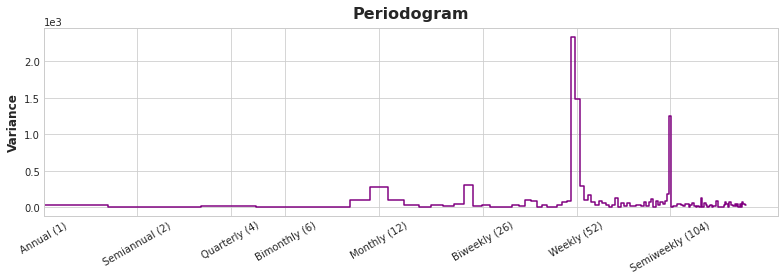

In [44]:
plot_periodogram(average_sales.loc['2017']);

📌 **Interpret:** both the seasonal plot and the periodogram suggest a strong weekly seasonality, and a weak annual seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

In [45]:
OH_train

,id,date,store_nbr,family,sales,onpromotion,city,state,cluster,dcoilwtico,...,6,7,8,9,10,11,12,13,14,15
1782,1782,2013-01-02,1,0.0,2.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1783,1783,2013-01-02,1,1.0,0.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1784,1784,2013-01-02,1,2.0,2.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1785,1785,2013-01-02,1,3.0,1091.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1786,1786,2013-01-02,1,4.0,0.000,0,18.0,12.0,13,93.14,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,28.0,438.133,0,18.0,12.0,6,47.57,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3054344,3000884,2017-08-15,9,29.0,154.553,1,18.0,12.0,6,47.57,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3054345,3000885,2017-08-15,9,30.0,2419.729,148,18.0,12.0,6,47.57,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3054346,3000886,2017-08-15,9,31.0,121.000,8,18.0,12.0,6,47.57,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
training_set = OH_train.copy()
training_set['date'] = training_set.date.dt.to_period('D')
training_set = training_set.set_index(['state','city','cluster','store_nbr', 'family', 'date']).sort_index()

In [47]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

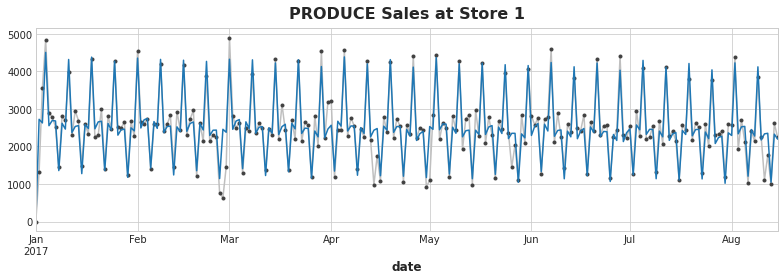

In [48]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [49]:
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)